### Loading libraries and data.

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from scipy.stats import entropy
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [23]:
# Import and preprate the data
D = h5py.File('breast.h5', 'r') 
X,Y,P = D['images'],np.array(D['counts']),np.array(D['id'])

In [24]:
X = X[:,16:283,16:283,:]

In [51]:
#hed_data = np.load("hed_data.npy")
#projected_blue_train = np.load("projected_blue_train.npy")
#projected_green_train = np.load("projected_green_train.npy")
#projected_red_train = np.load("projected_red_train.npy")
#projected_brown_train = np.load("projected_brown_train.npy")
hed_blue = np.load("hed_blue.npy")

## Question 1


### i) Data breakdown

In [6]:
# number of train examples
np.sum(P<14)

5841

In [7]:
# number of test examples
np.sum(P>=14)

1563

### ii) Showing Images

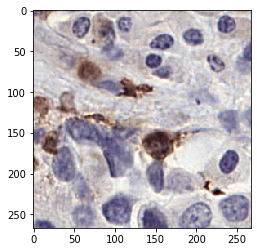

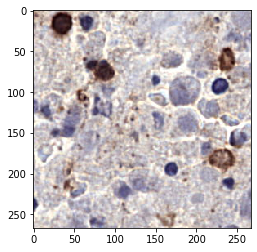

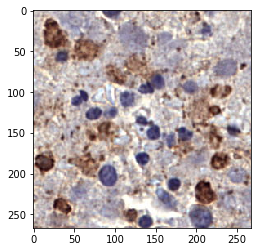

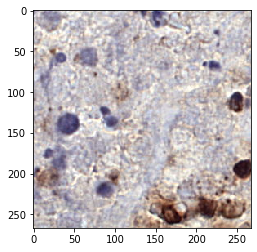

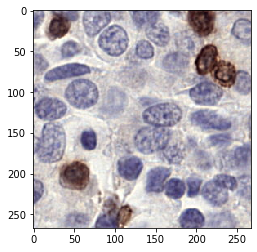

In [109]:
for i in range(0,5): 
    plt.imshow(X[i])
    plt.show()

In [110]:
Y[0:5]

array([4, 4, 9, 5, 6], dtype=int32)

(array([6.438e+03, 6.690e+02, 1.930e+02, 5.800e+01, 3.300e+01, 9.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.,  7., 14., 21., 28., 35., 42., 49., 56., 63., 70.]),
 <a list of 10 Patch objects>)

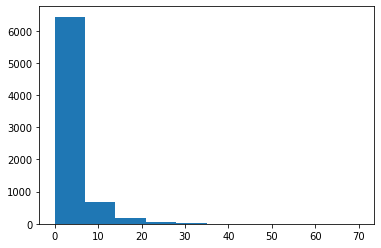

In [111]:
plt.hist(Y)

(array([5544., 1078.,  382.,  171.,  100.,   53.,   30.,   22.,   11.,
           6.]),
 array([ 0. ,  3.9,  7.8, 11.7, 15.6, 19.5, 23.4, 27.3, 31.2, 35.1, 39. ]),
 <a list of 10 Patch objects>)

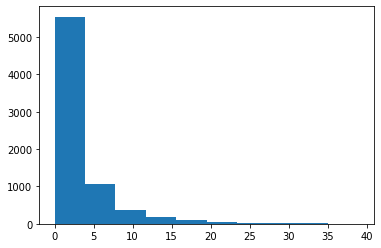

In [112]:
plt.hist(Y[Y<40])

In [12]:
np.sum(Y>40)

5

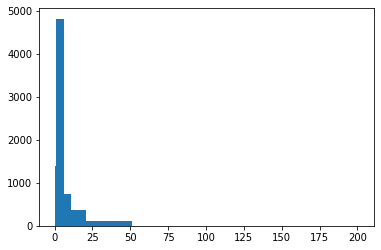

In [13]:
(histogram_counts, bins, _) = plt.hist(Y, bins = [0,1,6,11,21,51,201])
plt.show()

In [14]:
np.set_printoptions(suppress=True)
print(histogram_counts)
print(bins)

[1397. 4811.  736.  356.  103.    1.]
[  0   1   6  11  21  51 201]


In [15]:
np.max(Y)

70

### iv) Pre-processing

In [113]:
cmap_hema = LinearSegmentedColormap.from_list('mycmap', ['white', 'navy'])
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white',
                                             'saddlebrown'])
cmap_eosin = LinearSegmentedColormap.from_list('mycmap', ['darkviolet',
                                               'white'])

In [114]:
hed_data = rgb2hed(X[:1000,:,:,:])
hed_data = (hed_data[:,:,:,2] * 128).astype("int8")

In [115]:
hed_data_2 = rgb2hed(X[1000:2000])
hed_data_2 = (hed_data_2[:,:,:,2] * 128).astype("int8")

In [116]:
hed_data = np.vstack((hed_data, hed_data_2))

In [117]:
hed_data_2 = rgb2hed(X[2000:3000])
hed_data_2 = (hed_data_2[:,:,:,2] * 128).astype("int8")

In [118]:
hed_data = np.vstack((hed_data, hed_data_2))

In [119]:
hed_data_2 = rgb2hed(X[3000:4000])
hed_data_2 = (hed_data_2[:,:,:,2] * 128).astype("int8")

In [120]:
hed_data = np.vstack((hed_data, hed_data_2))

In [121]:
hed_data_2 = rgb2hed(X[4000:5000])
hed_data_2 = (hed_data_2[:,:,:,2] * 128).astype("int8")

In [122]:
hed_data = np.vstack((hed_data, hed_data_2))

In [123]:
hed_data_2 = rgb2hed(X[5000:6000])
hed_data_2 = (hed_data_2[:,:,:,2] * 128).astype("int8")

In [124]:
hed_data = np.vstack((hed_data, hed_data_2))

In [125]:
hed_data_2 = rgb2hed(X[6000:])
hed_data_2 = (hed_data_2[:,:,:,2] * 128).astype("int8")

In [126]:
hed_data = np.vstack((hed_data, hed_data_2))
del(hed_data_2)
np.save("hed_data", hed_data)

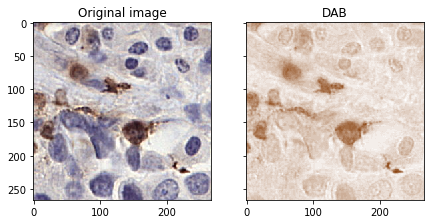

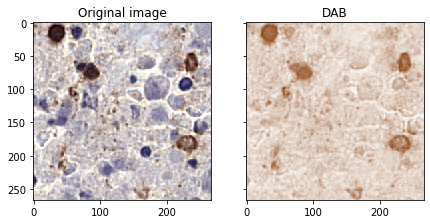

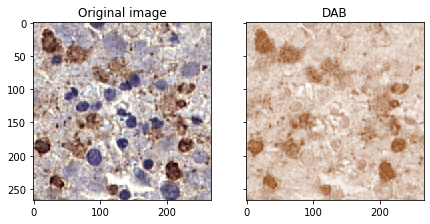

In [127]:
for i in range(0,3):
  fig, axes = plt.subplots(1, 2, figsize=(7, 6), sharex=True, sharey=True)
  ax = axes.ravel()
  ax[0].imshow(X[i,])
  ax[0].set_title("Original image")

  ax[1].imshow(hed_data[i,], cmap=cmap_dab)
  ax[1].set_title("DAB")

### v) Scatter Plot

In [49]:
average_brown = []
for i in range(0, np.shape(hed_data)[0]):
    average_brown.append(np.mean(hed_data[i]))
    
average_brown = np.asarray(average_brown)  

In [130]:
print(average_brown)
np.save("average_brown", average_brown)

[-48.15800474 -48.20376215 -46.21118265 ... -52.44981694 -52.33327722
 -52.41957385]


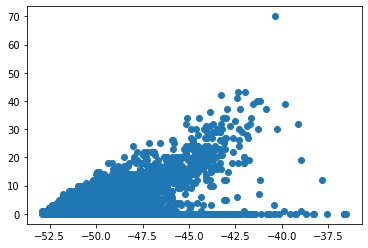

In [131]:
plt.scatter(average_brown, Y)

So there is strong possitive correlation. The higher the number - the more "browness" there is. A lot of zero values for the cell count too and they correspond to different shades of brown which might lead to miscalculations. Looking into pictures, we see that the size of the brown cells varies, and if they are smaller it might appear that the iamge is less brown, but the count of the, nonetheless, can be non-zero. Hence, this is a problem and we need to look for additional covariates.

In [132]:
np.unique(P, return_counts = True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18], dtype=int32),
 array([320, 465, 958, 192,  44, 105,  83, 632, 533, 552, 761, 791, 405,
        105, 399, 604, 103, 352]))

I do not think it is a problem. We are not looking into person specific problem, but instead we want to develop an algorithm that could predict the number of cells given any image. We must not rely on the prior knowledge - the prior cell count of the person. If we were to include covariates such as age, gender, lifestyle, etc to improve our anlysis then the individual counts might be more important.

### vii) Performance measure

MAE, I see some big outliers, there is no way the model predicts it well, the MSE and RMSE will explode. But I consider deleting an observation with value of 70 - likelly to have high Cook's distance.

In [133]:
Y[1972:2023]

array([ 3,  5,  0, 11,  0,  1,  0,  0,  1,  2,  5,  1,  3,  5,  7,  1,  1,
        3,  1,  3,  4,  2,  0,  3,  1,  1,  0,  1,  4,  9,  1,  2,  0,  2,
        5,  2,  1,  0,  9,  2,  1,  1,  2,  2,  2,  3,  3,  7,  0,  2,  4],
      dtype=int32)

## Question 2

### i) Extracting features

### a. Averages

In [182]:
# average brown from before
average_brown

array([-48.15800474, -48.20376215, -46.21118265, ..., -52.44981694,
       -52.33327722, -52.41957385])

In [45]:
# average red
average_red = []
for i in range(0, np.shape(X)[0]):
    average_red.append(np.mean(X[i,:,:,1]))
    
average_red = np.asarray(average_red)    
np.save("average_red", average_red)

In [47]:
# average green
average_green = []
for i in range(0, np.shape(X)[0]):
    average_green.append(np.mean(X[i,:,:,1]))
    
average_green = np.asarray(average_green)    
# Saving cause I am not runnig this again. God...
np.save("average_green", average_green)

In [48]:
# average blue
average_blue = []
for i in range(0, np.shape(X)[0]):
    average_blue.append(np.mean(X[i,:,:,2]))
average_blue = np.asarray(average_blue)
np.save("average_blue", average_blue)

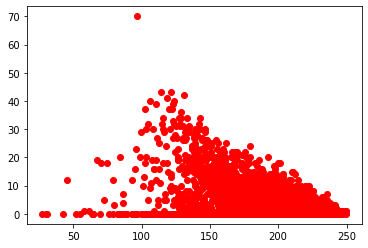

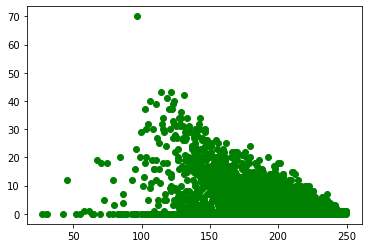

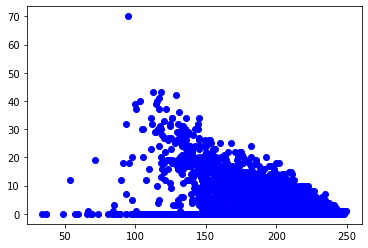

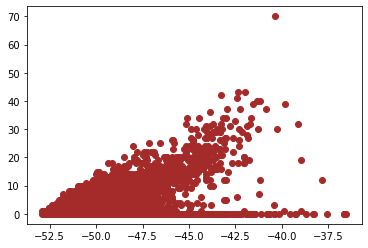

In [185]:
plt.scatter(average_red, Y, color="red")
plt.show()
plt.scatter(average_green, Y, color="green")
plt.show()
plt.scatter(average_blue, Y, color="blue")
plt.show()
plt.scatter(average_brown, Y, color="brown")
plt.show()

Browness seems like a reasonble good predictor with some noise at zeros counts (it was artificially created).
RGB are also good but it might be the case that one of them is enough since they show very similar trend.

### b. Variance

In [20]:
#hed_data = np.load("hed_data.npy")

In [54]:
variance_brown = []
for i in range(0, np.shape(hed_data)[0]):
    variance_brown.append(np.var(hed_data[i]))
    
variance_brown = np.asarray(variance_brown)
np.save("variance_brown", variance_brown)

In [55]:
variance_red = []
for i in range(0, np.shape(X)[0]):
    variance_red.append(np.var(X[i,:,:,0]))
    
variance_red = np.asarray(variance_red)
np.save("variance_red", variance_red)

In [56]:
variance_green = []
for i in range(0, np.shape(X)[0]):
    variance_green.append(np.var(X[i,:,:,1]))
    
variance_green = np.asarray(variance_green)
np.save("variance_green", variance_green)

In [57]:
variance_blue = []
for i in range(0, np.shape(X)[0]):
    variance_blue.append(np.var(X[i,:,:,2]))
    
variance_blue = np.asarray(variance_blue)
np.save("variance_blue", variance_blue)

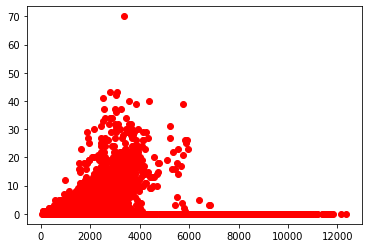

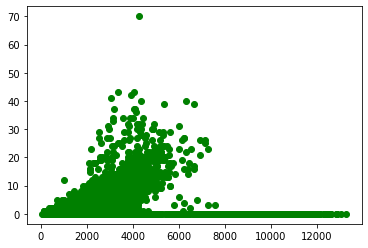

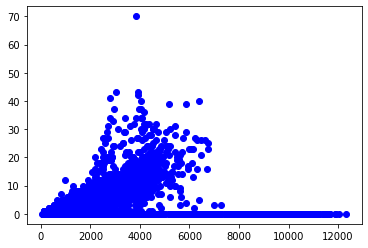

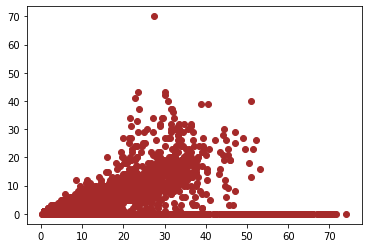

In [186]:
plt.scatter(variance_red, Y, color="red")
plt.show()
plt.scatter(variance_green, Y, color="green")
plt.show()
plt.scatter(variance_blue, Y, color="blue")
plt.show()
plt.scatter(variance_brown, Y, color="brown")
plt.show()

Seems to be worse than the average. The noise is super bad here. Considering of ommittin it. 

### c. Entropy

In [21]:
# entropy red
entropy_red = []
for i in range(0, np.shape(X)[0]):
    entropy_red.append(entropy(np.reshape(X[i,:,:,0], (267*267, 1))))
    
entropy_red = np.asarray(entropy_red)    
np.save("entropy_red", entropy_red)

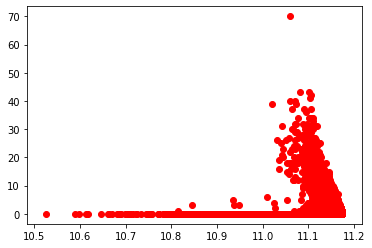

In [23]:
plt.scatter(entropy_red, Y, color="red")
plt.show()

In [25]:
# entropy green
entropy_green = []
for i in range(0, np.shape(X)[0]):
    entropy_green.append(entropy(np.reshape(X[i,:,:,1], (267*267, 1))))
    
entropy_green = np.asarray(entropy_green)    
np.save("entropy_green", entropy_green)

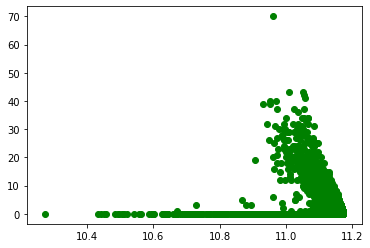

In [25]:
plt.scatter(entropy_green, Y, color="green")
plt.show()

In [26]:
# entropy blue
entropy_blue = []
for i in range(0, np.shape(X)[0]):
    entropy_blue.append(entropy(np.reshape(X[i,:,:,2], (267*267, 1))))
    
entropy_blue = np.asarray(entropy_blue)    
np.save("entropy_blue", entropy_blue)

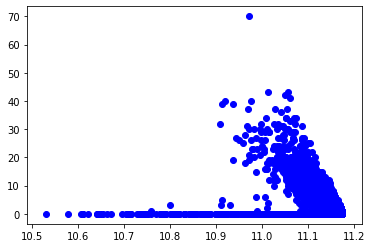

In [27]:
plt.scatter(entropy_blue, Y, color="blue")
plt.show()

In [31]:
# entropy blue
entropy_brown = []
for i in range(0, np.shape(hed_data)[0]):
    entropy_brown.append(entropy(np.reshape(hed_data[i], (267*267, 1))))
    
entropy_brown = np.asarray(entropy_brown)    
np.save("entropy_brown", entropy_brown)

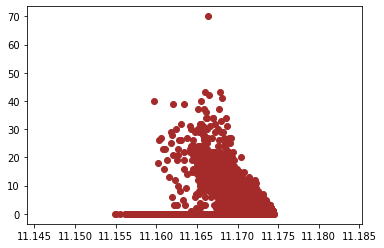

In [32]:
plt.scatter(entropy_brown, Y, color="brown")
plt.show()

### d. Histograms

(array([   40.,   327.,   739.,  1041.,  1523.,  2798.,  5071.,  7055.,
        10627., 16879., 16748.,  7830.]),
 array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240]),
 <a list of 12 Patch objects>)

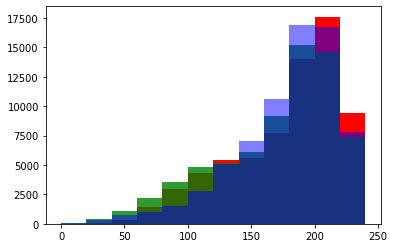

In [144]:
plt.hist(np.reshape(X[0,:,:,0], (267*267,1)), list(range(0,256, 20)), color = "red")
plt.hist(np.reshape(X[0,:,:,1], (267*267,1)), list(range(0,256, 20)), color = "green", alpha=0.8)
plt.hist(np.reshape(X[0,:,:,2], (267*267,1)), list(range(0,256, 20)), color = "blue", alpha=0.5)

(array([  628.,  4687., 10861., 16768., 17546., 12904., 14067.,  3282.,
         1916.,  1185.,   808.,   763.,   862.,  1645.,   631.,   454.,
          245.,    82.,    38.,    29.]),
 array([-54.  , -52.85, -51.7 , -50.55, -49.4 , -48.25, -47.1 , -45.95,
        -44.8 , -43.65, -42.5 , -41.35, -40.2 , -39.05, -37.9 , -36.75,
        -35.6 , -34.45, -33.3 , -32.15, -31.  ]),
 <a list of 20 Patch objects>)

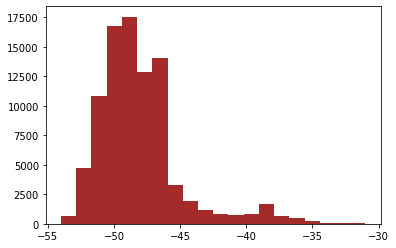

In [131]:
plt.hist(np.reshape(hed_data[0], (267*267,1)), bins = 20, color = "brown")

(array([  145.,  2616.,  4078.,  3744.,  3048.,  2875.,  3025.,  4603.,
         7394., 14485., 18874.,  6310.]),
 array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240]),
 <a list of 12 Patch objects>)

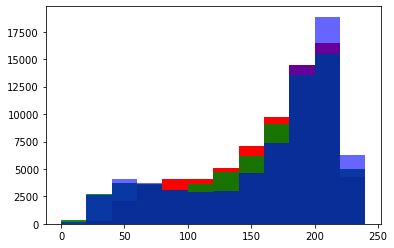

In [145]:
plt.hist(np.reshape(X[3000,:,:,0], (267*267,1)), bins = list(range(0,256, 20)), color = "red")
plt.hist(np.reshape(X[3000,:,:,1], (267*267,1)), bins = list(range(0,256, 20)), color = "green", alpha=0.9)
plt.hist(np.reshape(X[3000,:,:,2], (267*267,1)), bins = list(range(0,256, 20)), color = "blue", alpha=0.6)

(array([  464.,  4715., 14453., 15060.,  7510.,  3968.,  2314.,  1762.,
         1665.,  1560.,  3294.,  1698.,  1728.,  2014.,  2188.,  2344.,
         2212.,  1655.,   630.,    55.]),
 array([-54. , -52.9, -51.8, -50.7, -49.6, -48.5, -47.4, -46.3, -45.2,
        -44.1, -43. , -41.9, -40.8, -39.7, -38.6, -37.5, -36.4, -35.3,
        -34.2, -33.1, -32. ]),
 <a list of 20 Patch objects>)

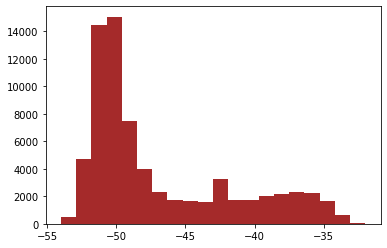

In [146]:
plt.hist(np.reshape(hed_data[3000], (267*267,1)), bins = 20, color = "brown")

### e. PC decomposition

Will run separatelly on training and testing data

In [358]:
pca_red = PCA(1000, svd_solver='randomized')
projected_2 = pca_red.fit_transform(np.reshape(X[:2000,:,:,0],(2000, 267*267)))

In [359]:
np.sum(pca_red.explained_variance_ratio_)

0.9520272617628207

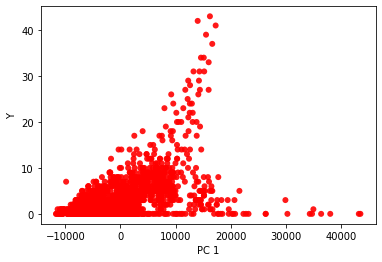

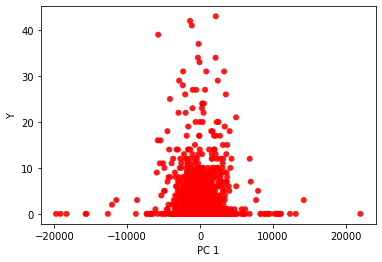

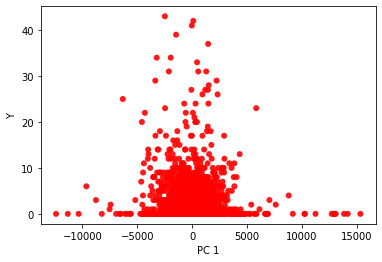

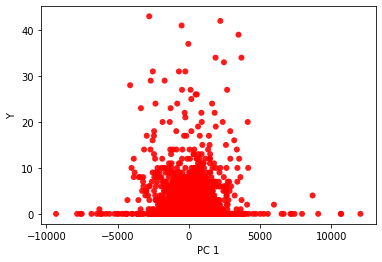

In [149]:
for i in range(0,4):
    plt.scatter(projected_2[:, i], Y[:2000], edgecolor='none', alpha=0.9, color = "red")
    plt.xlabel('PC 1')
    plt.ylabel( 'Y')
    plt.show()

In [150]:
pca_5_green = PCA(5, svd_solver="randomized")
projected_2_green = pca_5_green.fit_transform(np.reshape(X[:2000,:,:,1],(2000, 267*267)))

In [151]:
pca_5_green.explained_variance_ratio_

array([0.23794303, 0.02699449, 0.02053791, 0.01363475, 0.01238108])

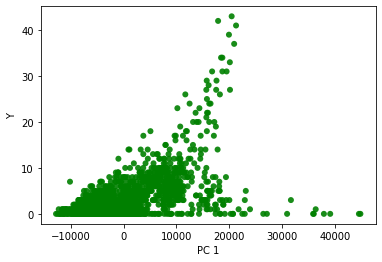

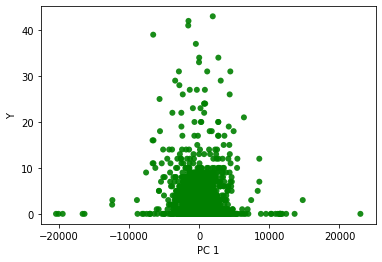

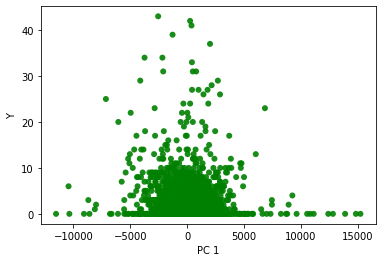

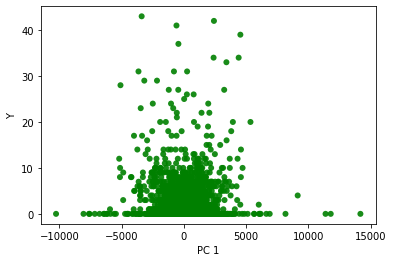

In [152]:
for i in range(0,4):
    plt.scatter(projected_2_green[:, i], Y[:2000], edgecolor='none', alpha=0.9, color = "green")
    plt.xlabel('PC 1')
    plt.ylabel( 'Y')
    plt.show()

In [153]:
pca_5_blue = PCA(5, svd_solver="randomized")
projected_2_blue = pca_5_blue.fit_transform(np.reshape(X[:2000,:,:,2],(2000, 267*267)))

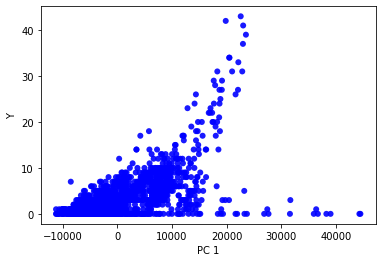

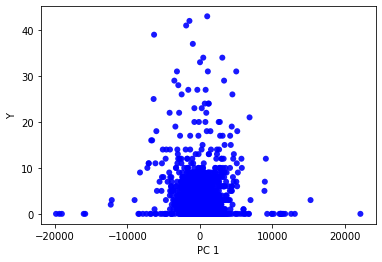

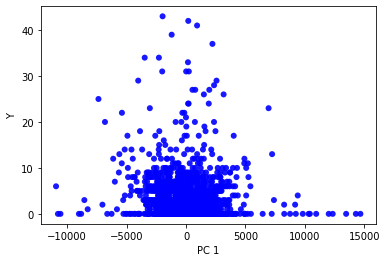

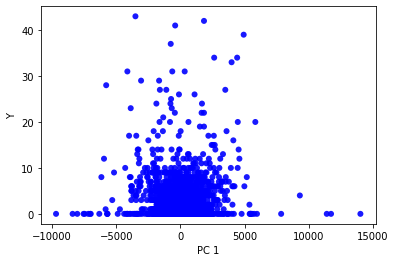

In [154]:
for i in range(0,4):
    plt.scatter(projected_2_blue[:, i], Y[:2000], edgecolor='none', alpha=0.9, color = "blue")
    plt.xlabel('PC 1')
    plt.ylabel('Y')
    plt.show()

In [28]:
#hed_data = np.load("hed_data.npy")

In [155]:
pca_5_brown = PCA(5, svd_solver="randomized")
projected_2_brown = pca_5_brown.fit_transform(np.reshape(hed_data[:2000] ,(2000, 267*267)))

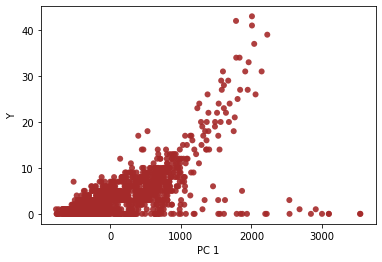

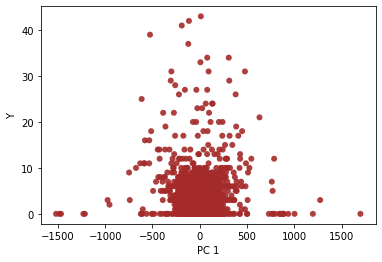

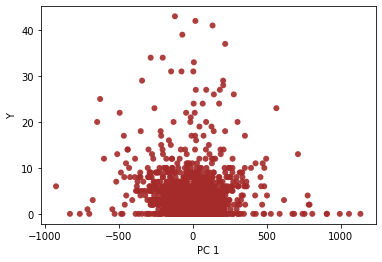

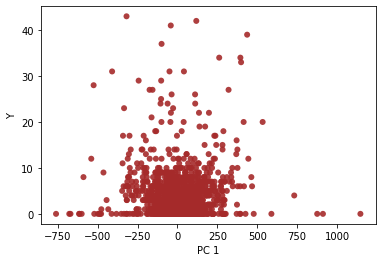

In [156]:
for i in range(0,4):
    plt.scatter(projected_2_brown[:, i], Y[:2000], edgecolor='none', alpha=0.9, color = "brown")
    plt.xlabel('PC 1')
    plt.ylabel( 'Y')
    plt.show()

First principal component of all the channels seems to be informative with the rest not being informative. This is because they explain over 20% variation with the rest explaining only a fraction. Even though the shapes of RGB PC1 seem the same, their range on PC1 axis is different. Thus I consider putting all the PC1s into the model. 

Now I will create vectors of PC1 for each channel. Separatelly for training and testing data.

In [360]:
pca_red_train = PCA(1300, svd_solver='randomized')
projected_red_train = pca_red_train.fit_transform(np.reshape(X[:5841,:,:,0],(5841, 267*267)))

#np.save("projected_red_train", projected_red_train)
np.sum(pca_red_train.explained_variance_ratio_)

Explained variance ratio [0.23207383]


Text(0, 0.5, 'Y')

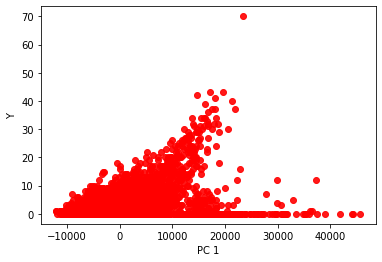

In [363]:
print('Explained variance ratio', pca_red_train.explained_variance_ratio_)
plt.scatter(projected_red_train[:, 0], Y[:5841], alpha=0.9, color='red')
plt.xlabel('PC 1')
plt.ylabel( 'Y')

In [ ]:
pca_green_train = PCA(1300, svd_solver='randomized')
projected_green_train = pca_green_train.fit_transform(np.reshape(X[:5841,:,:,1],(5841, 267*267)))

#np.save("projected_green_train", projected_green_train)
np.sum(pca_green_train.explained_variance_ratio_)

In [ ]:
print('Explained variance ratio', pca_green_train.explained_variance_ratio_)
plt.scatter(projected_green_train[:, 0], Y[:5841], alpha=0.9, color='green')
plt.xlabel('PC 1')
plt.ylabel( 'Y')

In [198]:
pca_blue_train = PCA(1300, svd_solver='randomized')
projected_blue_train = pca_blue_train.fit_transform(np.reshape(X[:5841,:,:,2],(5841, 267*267)))

#np.save("projected_blue_train", projected_blue_train)
np.sum(pca_blue_train.explained_variance_ratio_)

In [ ]:
print('Explained variance ratio', pca_blue_train.explained_variance_ratio_)
plt.scatter(projected_blue_train[:, 0], Y[:5841], alpha=0.9, color='blue')
plt.xlabel('PC 1')
plt.ylabel( 'Y')

In [ ]:
pca_brown_train = PCA(1300, svd_solver='randomized')
projected_brown_train = pca_brown_train.fit_transform(np.reshape(hed_data[:5841],(5841, 267*267)))

#np.save("projected_brown_train", projected_brown_train)
np.sum(pca_brown_train.explained_variance_ratio_)

Text(0, 0.5, 'Y')

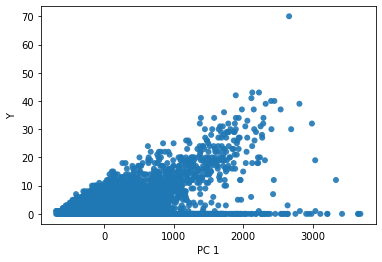

In [199]:
np.save("projected_brown_train", projected_brown_train)
plt.scatter(projected_full_brown[:, 0], Y[:5841], color = "brown", alpha = 0.9)
plt.xlabel('PC 1')
plt.ylabel( 'Y')

#### Test data

In [148]:
pca_red_test = PCA(1300, svd_solver='randomized')
projected_red_test = pca_red_test.fit_transform(np.reshape(X[5841:,:,:,0],(1563, 267*267)))

np.save("projected_red_test", projected_red_test)
np.sum(pca_red_test.explained_variance_ratio_)

0.9958162821723183

In [149]:
pca_green_test = PCA(1300, svd_solver='randomized')
projected_green_test = pca_green_test.fit_transform(np.reshape(X[5841:,:,:,1],(1563, 267*267)))

np.save("projected_green_test", projected_green_test)
np.sum(pca_green_test.explained_variance_ratio_)

0.9961827157943263

In [150]:
pca_blue_test = PCA(1300, svd_solver='randomized')
projected_blue_test = pca_blue_test.fit_transform(np.reshape(X[5841:,:,:,2],(1563, 267*267)))

np.save("projected_blue_test", projected_blue_test)
np.sum(pca_blue_test.explained_variance_ratio_)

0.9962742247086372

### f. My own features

From what I see, when there is a higher concentration of cells (blue and brown), the simple "browness" can be inadequare because the brown cells in the picture vary in size. So alongside this variable, I think it is worh including ration of brown cells to all cells. All cells can be extracted via H chanel. Then taking the ratio of "browness" to the "darkness" of the H chanel could help to separate brown cells from blue. 

In [157]:
hed = rgb2hed(X[0:1000])

Text(0.5, 1.0, 'DAB')

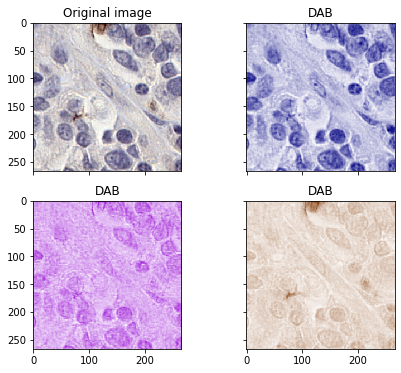

In [158]:
  fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
  ax = axes.ravel()
  ax[0].imshow(X[9,])
  ax[0].set_title("Original image")

  ax[1].imshow(hed[9,:,:,0], cmap=cmap_hema)
  ax[1].set_title("DAB")

  ax[2].imshow(hed[9,:,:,1], cmap=cmap_eosin)
  ax[2].set_title("DAB")

  ax[3].imshow(hed[9,:,:,2], cmap=cmap_dab)
  ax[3].set_title("DAB")

In [159]:
aveg_trial = []
for i in range(0,np.shape(hed)[0]):
    aveg_trial.append(np.mean(np.divide(hed[i,:,:,2],np.mean(hed[i,:,:,0]))))

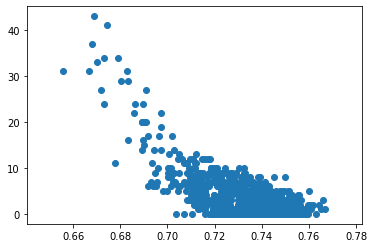

In [161]:
plt.scatter(aveg_trial, Y[:1000])

In [162]:
product_trial = []
for i in range(0,np.shape(hed)[0]):
    product_trial.append(np.mean(hed[i,:,:,2] - (hed[i,:,:,0])))

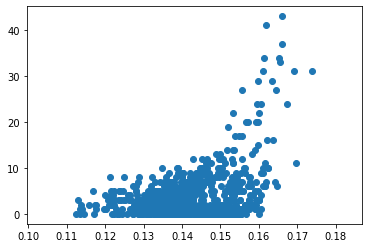

In [163]:
plt.scatter(product_trial, Y[:1000])

In [174]:
hed_blue = rgb2hed(X[:1000,:,:,:])
hed_blue = (hed_blue[:,:,:,0] * 128).astype("int8")

hed_blue_2 = rgb2hed(X[1000:2000])
hed_blue_2 = (hed_blue_2[:,:,:,0] * 128).astype("int8")

hed_blue = np.vstack((hed_blue, hed_blue_2))

hed_blue_2 = rgb2hed(X[2000:3000])
hed_blue_2 = (hed_blue_2[:,:,:,0] * 128).astype("int8")

hed_blue = np.vstack((hed_blue, hed_blue_2))

hed_blue_2 = rgb2hed(X[3000:4000])
hed_blue_2 = (hed_blue_2[:,:,:,0] * 128).astype("int8")

hed_blue = np.vstack((hed_blue, hed_blue_2))

hed_blue_2 = rgb2hed(X[4000:5000])
hed_blue_2 = (hed_blue_2[:,:,:,0] * 128).astype("int8")

hed_blue = np.vstack((hed_blue, hed_blue_2))

hed_blue_2 = rgb2hed(X[5000:6000])
hed_blue_2 = (hed_blue_2[:,:,:,0] * 128).astype("int8")

hed_blue = np.vstack((hed_blue, hed_blue_2))

hed_blue_2 = rgb2hed(X[6000:])
hed_blue_2 = (hed_blue_2[:,:,:,0] * 128).astype("int8")

hed_blue = np.vstack((hed_blue, hed_blue_2))
del(hed_blue_2)
np.save("hed_blue", hed_blue)

In [28]:
hed_blue = np.load("hed_blue.npy")
hed_data = np.load("hed_data.npy")
ratio_brown_blue = []
for i in range(0,np.shape(hed_blue)[0]):
    ratio_brown_blue.append(np.mean(hed_data[i,:,:])/(np.mean(hed_blue[i,:,:])))
np.save("ratio_brown_blue", ratio_brown_blue)

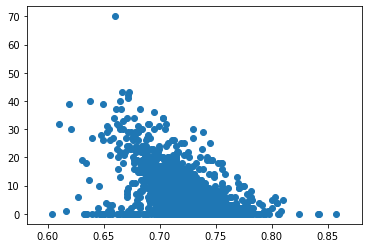

In [200]:
plt.scatter(ratio_brown_blue, Y)

In [175]:
difference_blue_brown = []
for i in range(0,np.shape(hed_blue)[0]):
    difference_blue_brown.append(np.mean(hed_blue[i,:,:] - (hed_data[i,:,:])))

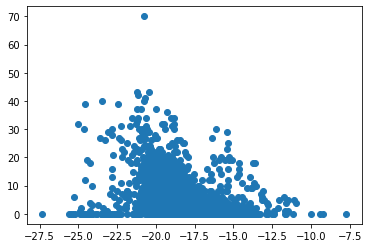

In [201]:
plt.scatter(difference_blue_brown, Y)

## ii) Model implementation

In [173]:
features_train = pd.concat([pd.DataFrame(projected_brown_train), pd.DataFrame(projected_green_train)],
                     axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(projected_red_train)], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(projected_blue_train)], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_red[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_green[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_brown[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(ratio_brown_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_green[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_brown[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_red[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_green[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_brown[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_red[:5841])], axis = 1)

features_train = features_train.to_numpy()
np.save("features_train_big", features_train)

### a. Linear Regression

I will not try the model with all the features. This is because then the number of variables 5213 is very close to the number of observations. This will lead to overfitting and it is extremelly likely that the likelihood of the model will be lower than the 2 times the number of variables. I thus procede immediatelly to a reduced case with 100 PCs of each channel only.

In [51]:
projected_brown_train = np.load("projected_brown_train.npy")
projected_blue_train = np.load("projected_blue_train.npy")
projected_green_train = np.load("projected_green_train.npy")
projected_red_train = np.load("projected_red_train.npy")
average_red = np.load("average_red.npy")
average_blue = np.load("average_blue.npy")
average_brown = np.load("average_brown.npy")
average_green = np.load("average_green.npy")
entropy_green = np.load("entropy_green.npy")
entropy_red = np.load("entropy_red.npy")
entropy_blue = np.load("entropy_blue.npy")
entropy_brown = np.load("entropy_brown.npy")
variance_green = np.load("variance_green.npy")
variance_red = np.load("variance_red.npy")
variance_blue = np.load("variance_blue.npy")
variance_brown = np.load("variance_brown.npy")


features_train_100 = pd.concat([pd.DataFrame(projected_brown_train[:,:100]), 
                            pd.DataFrame(projected_green_train[:,:100])],axis = 1)
features_train_100 = pd.concat([features_train_100, pd.DataFrame(projected_red_train[:,:100])], axis = 1)
features_train_100 = pd.concat([features_train_100, pd.DataFrame(projected_blue_train[:,:100])], axis = 1)
features_train_100 = pd.concat([features_train_100, pd.DataFrame(average_red[:5841])], axis = 1)
features_train_100 = pd.concat([features_train_100, pd.DataFrame(average_blue[:5841])], axis = 1)
features_train_100 = pd.concat([features_train_100, pd.DataFrame(average_green[:5841])], axis = 1)
features_train_100 = pd.concat([features_train_100, pd.DataFrame(average_brown[:5841])], axis = 1)
features_train_100 = pd.concat([features_train_100, pd.DataFrame(ratio_brown_blue[:5841])], axis = 1)
features_train_100 = pd.concat([features_train_100, pd.DataFrame(variance_blue[:5841])], axis = 1)
features_train_100 = pd.concat([features_train_100, pd.DataFrame(variance_green[:5841])], axis = 1)
features_train_100 = pd.concat([features_train_100, pd.DataFrame(variance_brown[:5841])], axis = 1)
features_train_100 = pd.concat([features_train_100, pd.DataFrame(variance_red[:5841])], axis = 1)
features_train_100 = pd.concat([features_train_100, pd.DataFrame(entropy_blue[:5841])], axis = 1)
features_train_100 = pd.concat([features_train_100, pd.DataFrame(entropy_green[:5841])], axis = 1)
features_train_100 = pd.concat([features_train_100, pd.DataFrame(entropy_brown[:5841])], axis = 1)
features_train_100 = pd.concat([features_train_100, pd.DataFrame(entropy_red[:5841])], axis = 1)

features_train_100 = features_train_100.to_numpy()

In [190]:
RMSE = []
R2 = []
MAE = []
for i, (train, test) in enumerate(kf.split(features_train_100, Y[:5841])):
    reg = sm.OLS(Y[:5841][train], features_train_100[train])
    results = reg.fit()
    print(results.aic)
    reg_predict = results.predict(features_train_100[test])
    MAE.append(mean_absolute_error(Y[:5841][test], reg_predict))
    RMSE.append(mean_squared_error(Y[:5841][test], reg_predict, squared = False))  
    R2.append(r2_score(Y[:5841][test], reg_predict))

17915.932947734043
16197.820279981475
18515.084535371818


In [187]:
print(np.mean(RMSE), np.mean(MAE), np.mean(R2))
# Much better. Try to leave only one PC

3.2162691019842247 1.7412230515392384 0.4868231355115508


In [191]:
features_train = pd.concat([pd.DataFrame(projected_brown_train[:,0]), pd.DataFrame(projected_green_train[:,0])],
                     axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(projected_red_train[:,0])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(projected_blue_train[:,0])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_red[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_green[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_brown[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(ratio_brown_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_green[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_brown[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_red[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_green[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_brown[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_red[:5841])], axis = 1)

features_train = features_train.to_numpy()

In [193]:
RMSE = []
R2 = []
MAE = []
for i, (train, test) in enumerate(kf.split(features_train, Y[:5841])):
    reg = sm.OLS(Y[:5841][train], features_train[train])
    results = reg.fit()
    print("AIC:", results.aic)
    reg_predict = results.predict(features_train[test])
    MAE.append(mean_absolute_error(Y[:5841][test], reg_predict))
    RMSE.append(mean_squared_error(Y[:5841][test], reg_predict, squared = False))  
    R2.append(r2_score(Y[:5841][test], reg_predict))

AIC: 18407.287233152525
AIC: 16827.80957982748
AIC: 18791.128460396038


In [194]:
print(np.mean(RMSE), np.mean(MAE), np.mean(R2))
# Much better. Look closer to coefficients

2.7526272067330493 1.6537236634997043 0.6324305708377197


In [195]:
results.summary()
# ommit the 13th variable

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              771.8
Date:                Sat, 29 Feb 2020   Prob (F-statistic):                        0.00
Time:                        17:04:40   Log-Likelihood:                         -9379.6
No. Observations:                3894   AIC:                                  1.879e+04
Df Residuals:                    3878   BIC:                                  1.889e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2637      0.098      2.701      0.007       0.072       0.455
x2             0.0094      0.008      1.156      0.248      -0.007       0.025
x3             0.0082      0.001     15.837      0.000       0.007       0.009
x4            -0.0366      0.016     -2.313      0.021      -0.068      -0.006
x5             1.3993      1.090      1.284      0.199      -0.738       3.537
x6            -6.6108      4.224     -1.565      0.118     -14.893       1.671
x7             1.3993      1.090      1.284      0.199      -0.738       3.537
x8           -50.8744     26.097     -1.949      0.051    -102.040       0.291
x9          -460.8421     65.144     -7.074      0.000    -588.562    -333.122
x10           -0.0180      0.001    -22.170      0.000      -0.020      -0.016
x11            0.0086      0.000     18.970      0.000       0.008       0.010
x12            1.3789      0.079     17.422      0.000       1.224       1.534
x13            0.0003      0.000      0.746      0.456      -0.001       0.001
x14          -48.5904     17.922     -2.711      0.007     -83.728     -13.453
x15          137.2730     12.031     11.410      0.000     113.685     160.861
x16         -180.9610     78.248     -2.313      0.021    -334.373     -27.549
x17          -33.8851     12.782     -2.651      0.008     -58.946      -8.824
==============================================================================
Omnibus:                     1502.135   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           189252.836
Skew:                           0.807   Prob(JB):                         0.00
Kurtosis:                      37.115   Cond. No.                     4.74e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.85e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [198]:
features_train = pd.concat([pd.DataFrame(projected_brown_train[:,0]), pd.DataFrame(projected_green_train[:,0])],
                     axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(projected_red_train[:,0])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(projected_blue_train[:,0])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_red[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_green[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_brown[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(ratio_brown_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_green[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_brown[:5841])], axis = 1)
#features_train = pd.concat([features_train, pd.DataFrame(variance_red[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_green[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_brown[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_red[:5841])], axis = 1)

features_train = features_train.to_numpy()

In [199]:
RMSE = []
R2 = []
MAE = []
for i, (train, test) in enumerate(kf.split(features_train, Y[:5841])):
    reg = sm.OLS(Y[:5841][train], features_train[train])
    results = reg.fit()
    print("AIC:", results.aic)
    reg_predict = results.predict(features_train[test])
    MAE.append(mean_absolute_error(Y[:5841][test], reg_predict))
    RMSE.append(mean_squared_error(Y[:5841][test], reg_predict, squared = False))  
    R2.append(r2_score(Y[:5841][test], reg_predict))

AIC: 18413.52551164616
AIC: 16831.450759381343
AIC: 18789.686680133727


In [200]:
print(np.mean(RMSE), np.mean(MAE), np.mean(R2))
# No beter than before

2.7073592580815085 1.6118983634565716 0.6448423116010753


In [201]:
results.summary()
# AIC unchanged, BIC went up. Better leave red_variance in. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              823.3
Date:                Sat, 29 Feb 2020   Prob (F-statistic):                        0.00
Time:                        17:07:18   Log-Likelihood:                         -9379.8
No. Observations:                3894   AIC:                                  1.879e+04
Df Residuals:                    3879   BIC:                                  1.888e+04
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2804      0.095      2.951      0.003       0.094       0.467
x2             0.0105      0.008      1.317      0.188      -0.005       0.026
x3             0.0084      0.000     17.247      0.000       0.007       0.009
x4            -0.0392      0.015     -2.543      0.011      -0.069      -0.009
x5             1.5522      1.071      1.450      0.147      -0.547       3.651
x6            -7.2858      4.126     -1.766      0.077     -15.375       0.803
x7             1.5522      1.071      1.450      0.147      -0.547       3.651
x8           -55.3770     25.388     -2.181      0.029    -105.151      -5.603
x9          -476.3235     61.743     -7.715      0.000    -597.376    -355.271
x10           -0.0177      0.001    -25.193      0.000      -0.019      -0.016
x11            0.0088      0.000     23.758      0.000       0.008       0.010
x12            1.3418      0.062     21.802      0.000       1.221       1.462
x13          -47.5162     17.863     -2.660      0.008     -82.538     -12.494
x14          140.5896     11.178     12.577      0.000     118.674     162.506
x15         -192.3033     76.751     -2.506      0.012    -342.780     -41.827
x16          -39.1629     10.643     -3.680      0.000     -60.030     -18.296
==============================================================================
Omnibus:                     1492.301   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           190253.518
Skew:                           0.791   Prob(JB):                         0.00
Kurtosis:                      37.207   Cond. No.                     5.78e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.89e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [249]:
features_train = pd.concat([pd.DataFrame(projected_brown_train[:,0]), pd.DataFrame(projected_green_train[:,0])],
                     axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(projected_red_train[:,0])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(projected_blue_train[:,0])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_red[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_green[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_brown[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(ratio_brown_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_green[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_brown[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_red[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_green[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_brown[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_red[:5841])], axis = 1)

feature_train = features_train.to_numpy()
# np.save("features_train_no_pc", feature_train)

#### Testing

In [29]:
projected_brown_test = np.load("projected_brown_test.npy")
projected_blue_test = np.load("projected_blue_test.npy")
projected_green_test = np.load("projected_green_test.npy")
projected_red_test = np.load("projected_red_test.npy")
average_red = np.load("average_red.npy")
average_blue = np.load("average_blue.npy")
average_brown = np.load("average_brown.npy")
average_green = np.load("average_green.npy")
entropy_green = np.load("entropy_green.npy")
entropy_red = np.load("entropy_red.npy")
entropy_blue = np.load("entropy_blue.npy")
entropy_brown = np.load("entropy_brown.npy")
variance_green = np.load("variance_green.npy")
variance_red = np.load("variance_red.npy")
variance_blue = np.load("variance_blue.npy")
variance_brown = np.load("variance_brown.npy")

# test matrix
features_test = pd.concat([pd.DataFrame(projected_brown_test[:,0]), pd.DataFrame(projected_green_test[:,0])],
                     axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(projected_red_test[:,0])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(projected_blue_test[:,0])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(average_red[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(average_blue[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(average_green[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(average_brown[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(ratio_brown_blue[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(variance_blue[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(variance_green[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(variance_brown[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(variance_red[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(entropy_blue[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(entropy_green[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(entropy_brown[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(entropy_red[5841:])], axis = 1)

features_test = features_test.to_numpy()
np.save("fetures_test_nopc", features_test)

In [206]:
reg_train = sm.OLS(Y[:5841], feature_train)
results = reg_train.fit()
reg_predict_test = results.predict(features_test) 
print("AIC:", results.aic)

AIC: 27316.234392776147


In [207]:
print(mean_squared_error(Y[5841:], reg_predict_test, squared = False),
      mean_absolute_error(Y[5841:], reg_predict_test),
     r2_score(Y[5841:], reg_predict_test))

3.632130230980054 2.4808952287479413 0.49731128239420685


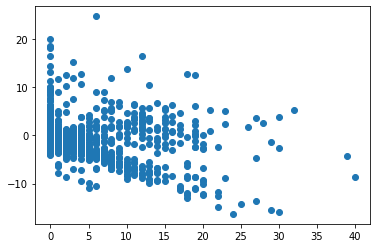

In [208]:
plt.scatter(Y[5841:], (reg_predict_test - Y[5841:]) )

### Multilayer perceptron

I have implemented Multilayer Perceptron using both: feature data with only one principal component for each channel and the feature data with 100 first principal components for each color channel. The latter data appeared to be always strictly worse than the smaller data, thus, saving space and your time I will NOT report the test results using 100 PC data.

In [49]:
from __future__ import absolute_import, division, print_function

import os

import tensorflow as tf
from tensorflow import keras

tf.__version__

'2.1.0'

In [ ]:
! pip 

Neural networks are stochastic, yet I will not set seed for the model choice purposes. I will, however, run the chosen neural network multiple times to get the rough estimate and confidence interval of my results. Also, for model choice purposes I will run the network for 100 epoches and will increase the number epoches for the chosen training model. 

In [73]:
# 1st model


# example of a model defined with the sequential api
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
kf = KFold(n_splits=3)

model1 = Sequential()
model1.add(Dense(10,input_dim=np.shape(features_train)[1],
                 kernel_initializer = 'uniform', activation='relu'))
model1.add(Dense(5,kernel_initializer = 'uniform', activation='relu'))
model1.add(Dense(2, kernel_initializer = 'uniform', activation='relu'))
model1.add(Dense(1,kernel_initializer = 'uniform', activation='linear'))
model1.compile(loss = 'MAE',optimizer='adam', metrics=['MAE', 'MSE'])


RMSE_m1 = []
MAE_m1 = []
R2_m1 = []

for i, (train, test) in enumerate(kf.split(features_train, Y[:5841])):
  if i == 0:
    checkpoint_path = "training_1/1st_model_1.ckpt" 
  elif i == 1:
    checkpoint_path = "training_1/1st_model_2.ckpt"
  elif i == 2:
    checkpoint_path = "training_1/1st_model_3.ckpt"

  checkpoint_dir = os.path.dirname(checkpoint_path)  
  cp_model1 = ModelCheckpoint(checkpoint_path, monitor = 'MAE',
                              save_weights_only=True,  
                              save_best_only=True, verbose=1)
  model1.fit(features_train[train],Y[:5841][train], nb_epoch = 100, 
             batch_size = 8, callbacks = [cp_model1], 
             validation_data = (features_train[test], Y[:5841][test]))
  
  #model1.load_weights(checkpoint_path)
  predicted = model1.predict(features_train[test], callbacks=[cp_model1])
  RMSE_m1.append(mean_squared_error(Y[:5841][test], predicted, squared= False))   
  MAE_m1.append(mean_absolute_error(Y[:5841][test], predicted))
  R2_m1.append(r2_score(Y[:5841][test], predicted))

Train on 3894 samples, validate on 1947 samples
Epoch 1/100
3808/3894 [============================>.] - ETA: 0s - loss: 2.4798 - MAE: 2.4798 - MSE: 21.5317
Epoch 00001: MAE improved from inf to 2.47369, saving model to training_1/1st_model_1.ckpt
3894/3894 [==============================] - 2s 595us/sample - loss: 2.4737 - MAE: 2.4737 - MSE: 21.4723 - val_loss: 2.2121 - val_MAE: 2.2121 - val_MSE: 15.0072
Epoch 2/100
3848/3894 [============================>.] - ETA: 0s - loss: 1.7275 - MAE: 1.7275 - MSE: 11.7354
Epoch 00002: MAE improved from 2.47369 to 1.72089, saving model to training_1/1st_model_1.ckpt
3894/3894 [==============================] - 2s 426us/sample - loss: 1.7209 - MAE: 1.7209 - MSE: 11.6905 - val_loss: 2.2464 - val_MAE: 2.2464 - val_MSE: 12.2997
Epoch 3/100
3736/3894 [===========================>..] - ETA: 0s - loss: 1.5071 - MAE: 1.5071 - MSE: 9.5994
Epoch 00003: MAE improved from 1.72089 to 1.49188, saving model to training_1/1st_model_1.ckpt
3894/3894 [============

In [74]:
print(np.mean(RMSE_m1), np.mean(MAE_m1), np.mean(R2_m1))
# roughly 2.3853235670647486 1.2509874720591823 0.7260309007066654
# 2.143290201259528 1.2105458127050504 0.7750789102641505
# 2.105522767359932 1.1133966891533837 0.7859736439039763
# 2.264755194142539 1.1616181857165866 0.7521255448392802
# 2.366976290642766 1.2711864425342334 0.7257288758616859

2.366976290642766 1.2711864425342334 0.7257288758616859


In [78]:
print( "RMSE:", np.mean([2.3853235670647486, 2.143290201259528, 2.105522767359932, 2.264755194142539, 2.366976290642766]),
 "MAE:", np.mean([1.2509874720591823, 1.2105458127050504, 1.1133966891533837, 1.1616181857165866, 1.2711864425342334]),
"R2:", np.mean([0.7260309007066654, 0.7750789102641505, 0.7859736439039763, 0.7521255448392802, 0.7257288758616859])
     )

RMSE: 2.253173604093903 MAE: 1.2015469204336875 R2: 0.7529875751151517


In [68]:
# model 3

model3 = Sequential()
model3.add(Dense(13,input_dim=np.shape(features_train)[1],
                 kernel_initializer = 'uniform', activation='relu'))
model3.add(Dense(8,kernel_initializer = 'uniform', activation='relu'))
model3.add(Dense(4, kernel_initializer = 'uniform', activation='relu'))
model3.add(Dense(1,kernel_initializer = 'uniform', activation='linear'))
model3.compile(loss = 'MAE',optimizer='adam',metrics=['MAE','MSE'])


RMSE_m3 = []
MAE_m3 = []
R2_m3 = []

for i, (train, test) in enumerate(kf.split(features_train, Y[:5841])):
  if i == 0:
    checkpoint_path = "training_1/3rd_model_1.ckpt" 
  elif i == 1:
    checkpoint_path = "training_1/3rd_model_2.ckpt"
  elif i == 2:
    checkpoint_path = "training_1/3rd_model_3.ckpt"

  checkpoint_dir = os.path.dirname(checkpoint_path)  
  cp_model3 = ModelCheckpoint(checkpoint_path, save_weights_only=True, 
                              save_best_only=True,  verbose=1,
                              monitor = 'MAE')
  model3.fit(features_train[train],Y[:5841][train], nb_epoch = 100, 
             batch_size = 8, callbacks = [cp_model3],
             validation_data = (features_train[test], Y[:5841][test]))
  
  #model1.load_weights(checkpoint_path)
  predicted = model3.predict(features_train[test], callbacks=[cp_model3])
  RMSE_m3.append(mean_squared_error(Y[:5841][test], predicted, squared= False))   
  MAE_m3.append(mean_absolute_error(Y[:5841][test], predicted))
  R2_m3.append(r2_score(Y[:5841][test], predicted))


Train on 3894 samples, validate on 1947 samples
Epoch 1/100
3784/3894 [============================>.] - ETA: 0s - loss: 2.4735 - MAE: 2.4735 - MSE: 24.4672
Epoch 00001: MAE improved from inf to 2.45047, saving model to training_1/3rd_model_1.ckpt
3894/3894 [==============================] - 2s 590us/sample - loss: 2.4505 - MAE: 2.4505 - MSE: 24.0070 - val_loss: 2.2127 - val_MAE: 2.2127 - val_MSE: 13.0276
Epoch 2/100
3856/3894 [============================>.] - ETA: 0s - loss: 2.0434 - MAE: 2.0434 - MSE: 19.4684
Epoch 00002: MAE improved from 2.45047 to 2.04035, saving model to training_1/3rd_model_1.ckpt
3894/3894 [==============================] - 3s 693us/sample - loss: 2.0403 - MAE: 2.0403 - MSE: 19.4374 - val_loss: 1.8603 - val_MAE: 1.8603 - val_MSE: 11.5759
Epoch 3/100
3720/3894 [===========================>..] - ETA: 0s - loss: 1.4942 - MAE: 1.4942 - MSE: 9.3401  ETA: 0s - loss: 1.5649 - MAE: 1.5649 - MSE
Epoch 00003: MAE improved from 2.04035 to 1.48204, saving model to trainin

In [69]:
print(np.mean(RMSE_m3), np.mean(MAE_m3), np.mean(R2_m3))
# roughly 2.2242435205598756 1.1067650254178014 0.7588107222460585
# 2.0992133684825593 1.1448822889267423 0.7847906110518396
# 2.2311722598095662 1.1231875207952875 0.7558747684356528
# 2.2940540830296015 1.233120393092819 0.7423223349654732
# 2.177588052790908 1.1759901003103512 0.7680401371611975

2.177588052790908 1.1759901003103512 0.7680401371611975


In [80]:
m3_summary = np.array([[2.2242435205598756, 1.1067650254178014, 0.7588107222460585],
[2.0992133684825593, 1.1448822889267423, 0.7847906110518396],
[2.2311722598095662, 1.1231875207952875, 0.7558747684356528],
[2.2940540830296015, 1.233120393092819, 0.7423223349654732],
[2.177588052790908, 1.1759901003103512, 0.7680401371611975]])

In [84]:
print( np.mean(m3_summary[:,0]), np.mean(m3_summary[:,1]), np.mean(m3_summary[:,2]))

2.205254256934502 1.1567890657086004 0.7619677147720443


#### Testing

In [87]:
checkpoint_path = "training_1/final_MLP.ckpt"

checkpoint_dir = os.path.dirname(checkpoint_path)  
cp_model3 = ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True,  verbose=1,
                              monitor = 'MAE')
model3.fit(features_train,Y[:5841], nb_epoch = 100, batch_size = 8, callbacks = [cp_model3])

Train on 5841 samples
Epoch 1/100
5816/5841 [============================>.] - ETA: 0s - loss: 0.9136 - MAE: 0.9136 - MSE: 3.1642 - ETA: 3s - loss: 0.8210 - MAE: 0.8210 - MSE: - ETA: 1s - loss: 0.8750 - MA
Epoch 00001: MAE improved from inf to 0.91679, saving model to training_1/final_MLP.ckpt
5841/5841 [==============================] - 2s 293us/sample - loss: 0.9168 - MAE: 0.9168 - MSE: 3.1858
Epoch 2/100
5752/5841 [============================>.] - ETA: 0s - loss: 0.9784 - MAE: 0.9784 - MSE: 4.8307
Epoch 00002: MAE did not improve from 0.91679
5841/5841 [==============================] - 2s 267us/sample - loss: 0.9796 - MAE: 0.9796 - MSE: 4.8157
Epoch 3/100
5712/5841 [============================>.] - ETA: 0s - loss: 1.0014 - MAE: 1.0014 - MSE: 5.1194
Epoch 00003: MAE did not improve from 0.91679
5841/5841 [==============================] - 2s 259us/sample - loss: 0.9949 - MAE: 0.9949 - MSE: 5.0422
Epoch 4/100
5768/5841 [============================>.] - ETA: 0s - loss: 0.9267 - MAE

In [88]:
predictions_test = model3.predict(features_test)

In [89]:
print(mean_squared_error(Y[5841:], predictions_test, squared = False),
      mean_absolute_error(Y[5841:], predictions_test),
     r2_score(Y[5841:], predictions_test))

2.77945625210469 1.268166165318047 0.7056283380748888


In [90]:
np.shape(features_train)

(5841, 17)

### Ridge Regression

In [33]:
features_train = np.load("features_train_nopc.npy")

In [34]:
parameters_ridge = [{'alpha': [0.1, 0.3, 0.5, 0.7, 0.8, 1]}]

ridge = Ridge()
ridge_clf = GridSearchCV(ridge, parameters_ridge, scoring = 'neg_mean_absolute_error', cv=kf)
ridge_clf.fit(features_train_100, Y[:5841])

NameError: name 'features_train_100' is not defined

In [248]:
print(ridge_clf.best_params_, "MAE:", ridge_clf.best_score_)

{'alpha': 0.1} MAE: -1.7884596224668738


In [35]:
parameters_ridge = [{'alpha': [0.1, 0.3, 0.5, 0.7, 0.8, 1]}]

ridge = Ridge()
ridge_clf = GridSearchCV(ridge, parameters_ridge, scoring = 'neg_mean_absolute_error', cv=kf)
ridge_clf.fit(features_train, Y[:5841])

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.1, 0.3, 0.5, 0.7, 0.8, 1]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [36]:
print(ridge_clf.best_params_, "MAE:", ridge_clf.best_score_)

{'alpha': 0.1} MAE: -1.7261290236589402


In [37]:
ridge_test = Ridge(alpha = 0.1)
ridge_test.fit(features_train, Y[:5841])
ridge_predict = ridge_test.predict(features_test)

In [38]:
print(mean_squared_error(Y[5841:], ridge_predict, squared = False),
      mean_absolute_error(Y[5841:], ridge_predict),
     r2_score(Y[5841:], ridge_predict))

3.401213518852263 1.9910601416434393 0.5591974406058022


### Support Vector Regression

In [ ]:
# Using Grid Search method to choose the most optimal kernel and parameters for SVM 
# Linear will not perform well so omitting it

param_SVR = [ {'kernel': ['poly'], 'degree': [2, 3], 'C': [0.01, 0.1, 1, 10, 100]},
              {'kernel': ['rbf'], 'gamma': [1e-2, 1e-4, 1, 10], 'C': [0.01, 0.1, 1, 10, 100]}]

svr = SVR()
svr_clf = GridSearchCV(svr, param_SVR, scoring = 'neg_mean_absolute_error', cv = kf)
svr_clf.fit(features_train, Y[:5841])

In [44]:
param_SVR= [{'kernel': ['poly'], 'degree': [2], 'C': [100, 500, 1000], 'epsilon' : [0.1, 0.5, 1]}]

svr = SVR()
svr_clf_2 = GridSearchCV(svr, param_SVR, scoring = 'neg_mean_absolute_error', cv = kf)
svr_clf_2.fit(features_train, Y[:5841])

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [100, 500, 1000], 'degree': [2],
                          'epsilon': [0.1, 0.5, 1], 'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [46]:
print(svr_clf_2.best_params_, "MAE:", svr_clf_2.best_score_)

{'C': 500, 'degree': 2, 'epsilon': 0.1, 'kernel': 'poly'} MAE: -1.5298433032510594


In [47]:
svr_train = SVR(kernel="poly", degree =2, C = 500, epsilon = 0.1)
svr_train.fit(features_train, Y[:5841])

SVR(C=500, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [48]:
svr_predict = svr_train.predict(features_test)

print(mean_squared_error(Y[5841:], svr_predict, squared = False),
      mean_absolute_error(Y[5841:], svr_predict),
     r2_score(Y[5841:], svr_predict))
# very odd; 4.5, 2.1 and 0.2

4.55965079796271 2.1178404475312944 0.2077915307201862
